<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Extracting-KSS-from-Drive" data-toc-modified-id="Extracting-KSS-from-Drive-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Extracting KSS from Drive</a></span></li><li><span><a href="#Getting-HRV-Files" data-toc-modified-id="Getting-HRV-Files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting HRV Files</a></span><ul class="toc-item"><li><span><a href="#KSS-File-Names" data-toc-modified-id="KSS-File-Names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>KSS File Names</a></span></li><li><span><a href="#Arranging-HRV-Dataframes" data-toc-modified-id="Arranging-HRV-Dataframes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Arranging HRV Dataframes</a></span></li><li><span><a href="#Arranging-KSS-Dataframes" data-toc-modified-id="Arranging-KSS-Dataframes-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Arranging KSS Dataframes</a></span></li></ul></li><li><span><a href="#Combining-Dataframes" data-toc-modified-id="Combining-Dataframes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Combining Dataframes</a></span></li><li><span><a href="#Assigning-1-min-Avg" data-toc-modified-id="Assigning-1-min-Avg-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Assigning 1 min Avg</a></span></li><li><span><a href="#Preprocessing-Features" data-toc-modified-id="Preprocessing-Features-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Preprocessing Features</a></span></li><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Baseline Model</a></span></li><li><span><a href="#Improving-the-Model" data-toc-modified-id="Improving-the-Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Improving the Model</a></span><ul class="toc-item"><li><span><a href="#LSTM" data-toc-modified-id="LSTM-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>LSTM</a></span></li><li><span><a href="#KNN" data-toc-modified-id="KNN-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>KNN</a></span></li></ul></li><li><span><a href="#Creating-KNN-Pipeline" data-toc-modified-id="Creating-KNN-Pipeline-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Creating KNN Pipeline</a></span><ul class="toc-item"><li><span><a href="#Saving-Trained-Pipeline" data-toc-modified-id="Saving-Trained-Pipeline-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Saving Trained Pipeline</a></span></li></ul></li><li><span><a href="#Getting-file-for-Prediction" data-toc-modified-id="Getting-file-for-Prediction-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Getting file for Prediction</a></span></li></ul></div>

# Extracting KSS from Drive

In [ ]:
def get_knn_pred_file(file_name):
    drive = Drive()
    folders = drive.list('folder', entire_drive = True)
    kss_folder = [folder['id'] for folder in folders if folder['name'] == 'KSS'][0]
    kss_files = drive.list('csv', add_query=f"'{kss_folder}' in parents", entire_drive = True)
    
    # id here??
    kss_df_drive = {}
    
    df = pd.read_csv(drive.download(file['id']))
    df.drop('Unnamed: 0', inplace=True, axis=1)
    kss_dfs_drive[file['name']] = df

get_knn_pred_file

In [1]:
from DDDS.drive import Drive
    drive = Drive()

    

Connected successfully!


In [2]:
folders = drive.list('folder', entire_drive = True)
kss_folder = [folder['id'] for folder in folders if folder['name'] == 'KSS'][0]
kss_files = drive.list('csv', add_query=f"'{kss_folder}' in parents", entire_drive = True)
kss_files



[{'id': '1Zg6pUamNDmVD-e1DaZWJTirqqGrD3TPf',
  'name': 'kss_2021-11-24 15-36-04 e99.csv'},
 {'id': '1aEzG0t1vFUVBBSNB1oHmDv-WcDIJWwTq',
  'name': 'kss_2021-10-25 10-31-58 c27.csv'},
 {'id': '1YrK7iQWaYn8CcLQ3a_zSsPw3w2WPoyq3',
  'name': 'kss_2021-11-30 16-16-03 ece.csv'},
 {'id': '15BBZCsmorqdFqOuawOEu3Lw6S76pGhfn',
  'name': 'kss_2021-11-19 13-38-33 ece.csv'},
 {'id': '1L7PlZ7QsclQV9mwaA5R8Cw5RPmgVhnOr',
  'name': 'kss_2021-11-26 15-16-28 ea9.csv'},
 {'id': '1U5LhUajEjeWXt0wTDwojDkTXwFrQfGrb',
  'name': 'kss_2021-11-29 13-48-17 eca.csv'},
 {'id': '1CvTl_9POgJ6KaTwk7SFpDnxJ-Yjg-bdP',
  'name': 'kss_2021-11-02 15-23-39 1c3.csv'},
 {'id': '1kGTySEyRtVg89tnyeOTnf3L6oWSDJTP1',
  'name': 'kss_2021-11-04 11-01-00 eca.csv'},
 {'id': '1EzOp-y63AOzWZdvwYw8-R8TSjStq4KOJ',
  'name': 'kss_2021-11-22 11-26-24 ea9.csv'},
 {'id': '1QdQOWG9tB1NHcEJmeEG1tjo1B6MLFd-6',
  'name': 'kss_2021-11-26 12-34-32 1c3.csv'},
 {'id': '1x2WqV1UlXg4rN14_13c3kwOp8Mel-qGO',
  'name': 'kss_2021-11-17 10-58-38 e99.csv'},

In [3]:
kss_dfs_drive = {}

for file in kss_files:
    df = pd.read_csv(drive.download(file['id']))
    df.drop('Unnamed: 0', inplace=True, axis=1)

    kss_dfs_drive[file['name']] = df



Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |█████████████████████████████████████████

# Getting HRV Files

In [5]:
hrv_list = [('28_10_2021', '844'),
 ('22_11_2021', 'eb0'),
 ('25_11_2021', 'ed2'),
 ('17_11_2021', 'e99'),
 ('25_10_2021', 'c27'),
 ('04_11_2021', 'ed2'),
 ('01_12_2021', 'e99'),
 ('24_11_2021', 'e99'),
 ('07_12_2021', 'ea9'),
 ('30_11_2021', 'ece'),
 ('30_11_2021', 'eb0'),
 ('05_11_2021', 'ed2'),
 ('22_11_2021', 'ea9'),
 ('24_11_2021', '038'),
 ('02_11_2021', '1c3'),
 ('29_11_2021', 'eca'),
 ('05_11_2021', 'ea9'),
 ('28_10_2021', '1c3'),
 ('26_10_2021', 'c04'),
 ('02_11_2021', 'eb0'),
 ('26_10_2021', 'c27'),
 ('19_11_2021', 'ece'),
 ('28_10_2021', '982'),
 ('24_11_2021', 'eca'),
 ('26_11_2021', '1c3'),
 ('25_11_2021', '038'),
 ('26_11_2021', 'ea9'),
 ('26_11_2021', 'ed2'),
 ('27_10_2021', '844'),
 ('04_11_2021', 'eca'),
 ('18_11_2021', 'e99'),
 ('25_10_2021', 'c04'),
 ('29_10_2021', '87e'),
 ('27_10_2021', '87e'),
 ('29_10_2021', '982')]

In [6]:
results_hrv = []
results_kss = []

for file in hrv_list:
    for key in kss_dfs_drive.keys():
        if '-'.join(file[0].split('_')[::-1]) in key and file[1] in key:
            results_hrv.append(file)
            results_kss.append(key)
            
results_hrv

[('17_11_2021', 'e99'),
 ('25_10_2021', 'c27'),
 ('01_12_2021', 'e99'),
 ('24_11_2021', 'e99'),
 ('07_12_2021', 'ea9'),
 ('30_11_2021', 'ece'),
 ('22_11_2021', 'ea9'),
 ('02_11_2021', '1c3'),
 ('29_11_2021', 'eca'),
 ('05_11_2021', 'ea9'),
 ('28_10_2021', '1c3'),
 ('26_10_2021', 'c27'),
 ('19_11_2021', 'ece'),
 ('24_11_2021', 'eca'),
 ('26_11_2021', '1c3'),
 ('26_11_2021', 'ea9'),
 ('04_11_2021', 'eca'),
 ('18_11_2021', 'e99')]

## KSS File Names

In [7]:
results_kss

['kss_2021-11-17 10-58-38 e99.csv',
 'kss_2021-10-25 10-31-58 c27.csv',
 'kss_2021-12-01 13-20-00 e99.csv',
 'kss_2021-11-24 15-36-04 e99.csv',
 'kss_2021-12-07 14-35-11 ea9.csv',
 'kss_2021-11-30 16-16-03 ece.csv',
 'kss_2021-11-22 11-26-24 ea9.csv',
 'kss_2021-11-02 15-23-39 1c3.csv',
 'kss_2021-11-29 13-48-17 eca.csv',
 'kss_2021-11-05 13-59-29 ea9.csv',
 'kss_2021-10-28 15-04-13 1c3.csv',
 'kss_2021-10-26 13-32-50 c27.csv',
 'kss_2021-11-19 13-38-33 ece.csv',
 'kss_2021-11-24 11-01-03 eca.csv',
 'kss_2021-11-26 12-34-32 1c3.csv',
 'kss_2021-11-26 15-16-28 ea9.csv',
 'kss_2021-11-04 11-01-00 eca.csv',
 'kss_2021-11-18 13-21-41 e99.csv']

## Arranging HRV Dataframes

In [8]:
from DDDS.hrv import HRV
hrv = HRV()

Connected successfully!


In [9]:
dataframes = hrv.get_dataframes()

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [10]:
def get_hrv_id(date, driver):
    """
    Returns key in hrv.dataframes dictionary corresponding to date and driver
    """
    for key in dataframes.keys():
        if date in key and driver in key:
            return key

In [11]:
key = get_hrv_id(*results_hrv[0])
key
test_df = dataframes[key]
test_df

,Timestamp_Google,Timestamp_Device,Device_id,Heart_Rate,RR_rate,Garmin
0,2021-11-17 09:58:22.566,2021-11-17 09:58:22.568,F1:4F:D8:DD:6A:C6,62,[619],1
1,2021-11-17 09:58:22.774,2021-11-17 09:58:22.771,CA:93:07:67:1E:FF,68,"[897, 905, 878, 904]",1
2,2021-11-17 09:58:22.807,2021-11-17 09:58:22.818,FD:9E:84:03:87:71,66,[],1
3,2021-11-17 09:58:23.293,2021-11-17 09:58:23.286,FD:9E:84:03:87:71,66,[],1
4,2021-11-17 09:58:23.498,2021-11-17 09:58:23.505,F1:4F:D8:DD:6A:C6,62,"[1016, 773]",1
...,...,...,...,...,...,...
12634,2021-11-17 11:05:03.944,2021-11-17 11:05:03.954,F1:4F:D8:DD:6A:C6,63,"[614, 293]",1
12635,2021-11-17 11:05:04.022,2021-11-17 11:05:04.032,FD:9E:84:03:87:71,61,[],1
12636,2021-11-17 11:05:04.542,2021-11-17 11:05:04.557,FD:9E:84:03:87:71,60,[],1
12637,2021-11-17 11:05:04.945,2021-11-17 11:05:04.963,F1:4F:D8:DD:6A:C6,63,[],1


In [49]:
for key in dataframes.keys():
    print(key)

22_11_2021_15_38 eb0
07_01_2022_13_56
05_01_2022_15_18
05_01_2022_15_14
05_01_2022_15_12
05_01_2022_15_07
05_01_2022_15_01
15_12_2021_11_23
15_12_2021_11_20
07_12_2021_14_35 ea9
07_12_2021_14_20
07_12_2021_14_13
01_12_2021_13_17 e99
01_12_2021_13_13
30_11_2021_16_12 ece
30_11_2021_12_32 eb0
26_11_2021_15_09 ea9
29_11_2021_13_47 eca
26_11_2021_12_31 1c3
26_11_2021_10_50 ed2
25_11_2021_13_42 ed2
25_11_2021_10_42 038
26_11_2021_10_44
25_11_2021_13_40
24_11_2021_15_34 e99
24_11_2021_13_40 038
25_11_2021_10_33
24_11_2021_15_18
24_11_2021_13_30
24_11_2021_10_52 eca
22_11_2021_11_22 ea9
19_11_2021_13_11 ece
19_11_2021_12_09
19_11_2021_12_04
19_11_2021_12_00
18_11_2021_13_19 e99
18_11_2021_12_53
17_11_2021_10_57 e99
17_11_2021_10_50
17_11_2021_10_47
05_11_2021_13_34 ea9
02_11_2021_15_17 1c3
02_11_2021_13_55 eb0
04_11_2021_10_57 eca
04_11_2021_13_43 ed2
05_11_2021_10_44 ed2
29_10_2021_13_32 982
04_11_2021_10_52
02_11_2021_11_36
28_10_2021_10_47 982
28_10_2021_14_57 1c3
26_10_2021_13_29 c27
27_1

In [13]:
# Get a list of HRV keys corresponding to Annotation DF
keys = []
for date, driver in results_hrv:
    keys.append(get_hrv_id(date, driver))
hrv_dfs_ordered = [dataframes[key] for key in keys]


## Arranging KSS Dataframes

In [22]:
kss_df_list = []
for key, val in kss_dfs_drive.items():
    kss_df_list.append(val)
    
kss_df_list[0]

,time_points,kss_value
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
4037,4037,5.0
4038,4038,5.0
4039,4039,5.0
4040,4040,5.0


# Combining Dataframes

In [26]:
import datetime as dt
import numpy as np
combined_dfs = []

# Combining KSS & HRV Dataframes...

for kss, hrv in zip(kss_df_list, hrv_dfs_ordered):
    
    # preprocessing hrv dataframes
    hrv['Timestamp_Google'] = hrv['Timestamp_Google'].dt.round('1s')
    hrv['time_points'] = hrv['Timestamp_Google'] - hrv['Timestamp_Google'].iloc[0]
    hrv['time_points']= hrv['time_points']/np.timedelta64(1,'s')
    hrv['time_points'] = hrv["time_points"].round().astype(int) 
    
    kss_start = kss[kss['kss_value'] != 0].time_points.iloc[0]
    hrv = hrv[hrv['time_points'] >=  kss_start]
    
    hrv['time_points'] = hrv['Timestamp_Google'] - hrv['Timestamp_Google'].iloc[0]
    hrv['time_points']= hrv['time_points']/np.timedelta64(1,'s')
    hrv['time_points'] = hrv["time_points"].round().astype(int) 
    
    df = hrv.merge(kss, on='time_points', how='left')
    
    df.drop('Timestamp_Device',inplace=True, axis=1, errors='ignore')
    df.drop('Device_id',inplace=True, axis=1, errors='ignore')
    
    df = df[df['kss_value'].notna()]

    combined_dfs.append(df)

/tmp/ipykernel_17643/75172008.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hrv['time_points'] = hrv['Timestamp_Google'] - hrv['Timestamp_Google'].iloc[0]
/tmp/ipykernel_17643/75172008.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hrv['time_points']= hrv['time_points']/np.timedelta64(1,'s')
/tmp/ipykernel_17643/75172008.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

/tmp/ipykernel_17643/75172008.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hrv['time_points'] = hrv['Timestamp_Google'] - hrv['Timestamp_Google'].iloc[0]
/tmp/ipykernel_17643/75172008.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hrv['time_points']= hrv['time_points']/np.timedelta64(1,'s')
/tmp/ipykernel_17643/75172008.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [69]:
combined_dfs[7]  #12:24....

,Timestamp_Google,Heart_Rate,RR_rate,Garmin,time_points,kss_value,min_group
0,2021-11-02 14:19:39,79,[],1,0,0.0,1.0
1,2021-11-02 14:19:39,76,[738],1,0,0.0,1.0
2,2021-11-02 14:19:39,79,[],1,0,0.0,1.0
3,2021-11-02 14:19:39,82,"[721, 720]",1,0,0.0,1.0
4,2021-11-02 14:19:40,79,[],1,1,0.0,1.0
...,...,...,...,...,...,...,...
16737,2021-11-02 15:29:00,83,[779],1,4161,6.0,70.0
16738,2021-11-02 15:29:01,84,[],1,4162,6.0,70.0
16739,2021-11-02 15:29:01,83,[],1,4162,6.0,70.0
16740,2021-11-02 15:29:01,83,[722],1,4162,6.0,70.0


# Assigning 1 min Avg

In [76]:
def hrv_prediction(df):
    df['min_group'] = ((df['time_points'] / 60) + 1).round(0)
    
 
    test_df = df.copy()

    new_df = pd.DataFrame(test_df.groupby('min_group'))

    last_df = pd.DataFrame()

    for group in new_df.index:

        list_RR = []
        working_df = test_df[test_df['min_group'] == group]

        for RR_rate in working_df.RR_rate:

            if RR_rate == '[]':
                # empty cell
                continue

            RR_rate = str(RR_rate).strip('[]')

            list_RR += [int(number) for number in RR_rate.split(', ')]

        if len(list_RR) == 0:
            continue
        working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
        last_df = last_df.append(working_df)
    
    last_df = last_df[['Timestamp_Google','Heart_Rate','one_min_RR_avg']]
        
    return last_df
    


In [77]:
hrv_prediction(combined_dfs[7])

/tmp/ipykernel_17643/2230418278.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/2230418278.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/2230418278.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/2230418278.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/2230418278.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/2230418278.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/2230418278.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/2230418278.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/2230418278.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/2230418278.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/2230418278.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/2230418278.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/2230418278.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/2230418278.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/2230418278.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/2230418278.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,Timestamp_Google,Heart_Rate,one_min_RR_avg
0,2021-11-02 14:19:39,79,807.480519
1,2021-11-02 14:19:39,76,807.480519
2,2021-11-02 14:19:39,79,807.480519
3,2021-11-02 14:19:39,82,807.480519
4,2021-11-02 14:19:40,79,807.480519
...,...,...,...
16524,2021-11-02 15:28:07,91,781.082803
16525,2021-11-02 15:28:08,83,781.082803
16526,2021-11-02 15:28:08,83,781.082803
16527,2021-11-02 15:28:08,75,781.082803


In [23]:
# len(combined_dfs)
# # 18 hrs total
# # 5min intervals
# 60 intervals in one hour
# 18 videos
# total = 216
# print(0.3 * 432)
# # change to one min to check!!

In [28]:
for df in combined_dfs:
    df['min_group'] = ((df['time_points'] / 60) + 1).round(0)
    
    
combined_dfs[0]
    

,Timestamp_Google,Heart_Rate,RR_rate,Garmin,time_points,kss_value,min_group
0,2021-11-17 09:58:58,65,[985],1,0,0.0,1.0
1,2021-11-17 09:58:58,67,[1354],1,0,0.0,1.0
2,2021-11-17 09:58:58,64,[],1,0,0.0,1.0
3,2021-11-17 09:58:58,64,[],1,0,0.0,1.0
4,2021-11-17 09:58:59,65,[963],1,1,0.0,1.0
...,...,...,...,...,...,...,...
12494,2021-11-17 11:05:04,63,"[614, 293]",1,3966,5.0,67.0
12495,2021-11-17 11:05:04,61,[],1,3966,5.0,67.0
12496,2021-11-17 11:05:05,60,[],1,3967,5.0,67.0
12497,2021-11-17 11:05:05,63,[],1,3967,5.0,67.0


In [29]:
final_dfs = []

for df in combined_dfs:    
    test_df = df.copy()

    new_df = pd.DataFrame(test_df.groupby('min_group'))

    last_df = pd.DataFrame()

    for group in new_df.index:

        list_RR = []
        working_df = test_df[test_df['min_group'] == group]

        for RR_rate in working_df.RR_rate:

            if RR_rate == '[]':
                # empty cell
                continue

            RR_rate = str(RR_rate).strip('[]')

            list_RR += [int(number) for number in RR_rate.split(', ')]

        if len(list_RR) == 0:
            continue
        working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
        last_df = last_df.append(working_df)
    
    final_dfs.append(last_df[['Timestamp_Google','Heart_Rate','kss_value','one_min_RR_avg']])

    


/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykernel_17643/3006224090.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_df = last_df.append(working_df)
/tmp/ipykernel_17643/3006224090.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['one_min_RR_avg'] = sum(list_RR) / len(list_RR)
/tmp/ipykerne

In [33]:
# list of averaged HRV dataframes
final_dfs[5].iloc[150:1000]

,Timestamp_Google,Heart_Rate,kss_value,one_min_RR_avg
150,2021-11-30 15:14:09,57,3.0,1040.011299
151,2021-11-30 15:14:10,57,3.0,1040.011299
152,2021-11-30 15:14:10,59,3.0,1040.011299
153,2021-11-30 15:14:10,65,3.0,1040.011299
154,2021-11-30 15:14:10,56,3.0,1040.011299
...,...,...,...,...
995,2021-11-30 15:17:43,84,3.0,847.569697
996,2021-11-30 15:17:43,69,3.0,847.569697
997,2021-11-30 15:17:44,84,3.0,847.569697
998,2021-11-30 15:17:44,73,3.0,847.569697


# Preprocessing Features

In [34]:
df_full = pd.DataFrame()

for df in final_dfs:
    df_full = df_full.append(df)
    


/tmp/ipykernel_17643/2793914243.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)
/tmp/ipykernel_17643/2793914243.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)
/tmp/ipykernel_17643/2793914243.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)
/tmp/ipykernel_17643/2793914243.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df)
/tmp/ipykernel_17643/2793914243.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.a

In [35]:
df_full

,Timestamp_Google,Heart_Rate,kss_value,one_min_RR_avg
0,2021-11-17 09:58:58,65,0.0,945.437500
1,2021-11-17 09:58:58,67,0.0,945.437500
2,2021-11-17 09:58:58,64,0.0,945.437500
3,2021-11-17 09:58:58,64,0.0,945.437500
4,2021-11-17 09:58:59,65,0.0,945.437500
...,...,...,...,...
15564,2021-11-18 13:26:11,66,7.0,929.653846
15565,2021-11-18 13:26:12,71,7.0,929.653846
15566,2021-11-18 13:26:12,65,7.0,929.653846
15567,2021-11-18 13:26:12,71,7.0,929.653846


In [36]:
def encode_target(row):
    if row['kss_value'] < 7 and row['kss_value'] >= 0:
        return 0
    else:
        return 1

In [37]:
df_full['kss_encoded'] = df_full.apply(lambda row: encode_target(row), axis=1)


(array([25216., 15504., 14025., 55183., 42532., 46036., 42790., 26752.,
         8859.,  2379.]),
 array([ 464.26262626,  531.45944056,  598.65625486,  665.85306915,
         733.04988345,  800.24669775,  867.44351204,  934.64032634,
        1001.83714064, 1069.03395493, 1136.23076923]),
 <BarContainer object of 10 artists>)

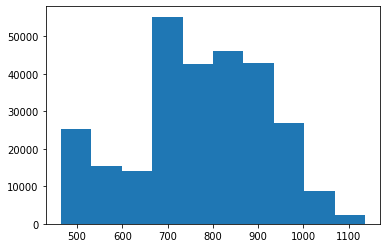

In [38]:
import matplotlib.pyplot as plt

plt.hist(df_full['one_min_RR_avg']) # Check feature distribution

<AxesSubplot:>

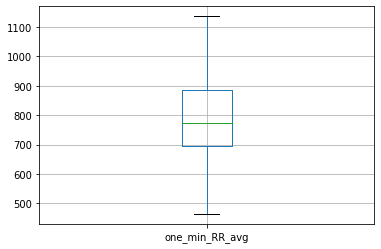

In [39]:
df_full[['one_min_RR_avg']].boxplot()


In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(df_full[['one_min_RR_avg']])

df_full['one_min_RR_avg'] = scaler.transform(df_full[['one_min_RR_avg']]) # Use scaler to transform data

(array([4.00000e+01, 0.00000e+00, 4.15200e+03, 8.58590e+04, 1.32917e+05,
        4.94230e+04, 4.44800e+03, 1.26100e+03, 1.03900e+03, 1.37000e+02]),
 array([-4.  , -3.09, -2.18, -1.27, -0.36,  0.55,  1.46,  2.37,  3.28,
         4.19,  5.1 ]),
 <BarContainer object of 10 artists>)

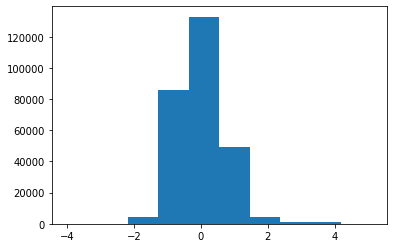

In [299]:
plt.hist(df_full['Heart_Rate']) # Check feature distribution

<AxesSubplot:>

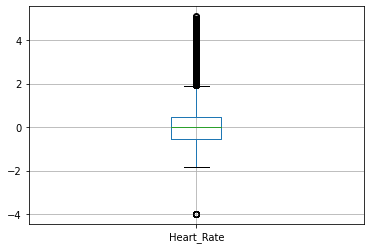

In [300]:
df_full[['Heart_Rate']].boxplot()


In [301]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

scaler.fit(df_full[['Heart_Rate']])

df_full['Heart_Rate'] = scaler.transform(df_full[['Heart_Rate']]) # Use scaler to transform data

In [53]:
plt.hist(df_full['kss_values'])

KeyError: 'kss_values'

# Baseline Model

In [84]:
X

,Heart_Rate,one_min_RR_avg
0,65,0.716068
1,67,0.716068
2,64,0.716068
3,64,0.716068
4,65,0.716068
...,...,...
15564,66,0.692579
15565,71,0.692579
15566,65,0.692579
15567,71,0.692579


In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

X = df_full[['Heart_Rate','one_min_RR_avg']]

y = df_full['kss_encoded']

model = KNeighborsClassifier(n_neighbors=3)

scores = cross_val_score(model, X, y, cv=10)

base_knn_score = scores.mean()

base_knn_score

0.5544304433848624

# Improving the Model

(array([127203.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 152073.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

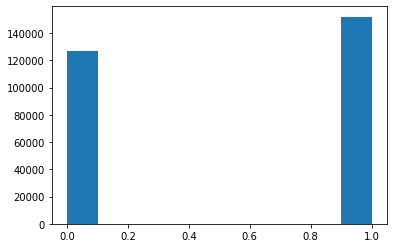

In [42]:
plt.hist(df_full['kss_encoded'])

(array([ 2044.,     0., 13561., 30535., 17449., 27722., 35892., 41083.,
        44200., 66790.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

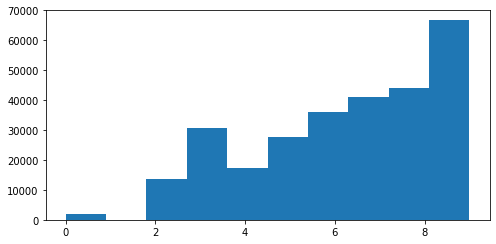

In [344]:
plt.hist(df_full['kss_value'])

## LSTM

In [ ]:
# --- LSTM ---
# 18 videos with validated data & kss scores
# each video split into 1-min intervals
# each interval has 2 features

# issue --> videos are not same length, some video dfs will have more 1-min intervals than others? how to fix this??


In [ ]:
# CNN ---
# use notebook structure for model
# try with all 9 classes to begin
# then try with same encoding structure to KNN to compare

## KNN

In [279]:
# Ks = [i for i in range(2,26)]
# scores = []

# for i in range(2,26):
#     model = KNeighborsClassifier(n_neighbors=i)

#     score = cross_val_score(model, X, y, cv=10)

#     knn_score = score.mean()

#     scores.append(knn_score)


In [82]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# define model
model = KNeighborsClassifier(n_neighbors=3)

# fit model
model.fit(X_train, y_train)

# make predictions
ypred = model.predict(X_test)

# evaluate predictions
accuracy = f1_score(y_test, ypred)
print(f'{round(accuracy*100,3)}%')

98.383%


In [67]:
y_test = y_test.values.T
y_test

array([0, 1, 0, ..., 1, 1, 0])

In [83]:
ypred

array([0, 0, 1, ..., 1, 0, 1])

In [63]:
ypred_proba = model.predict_proba(X_test)
ypred_proba = ypred_proba[:,1]

In [68]:
roc_auc_score(y_test, ypred_proba)


0.9940271866842247

In [337]:
ypred

array([0, 1, 0, 0, 0])

In [343]:
y_test

15932    5.0
13488    7.0
4625     3.0
208      2.0
1838     4.0
        ... 
7014     9.0
5763     7.0
14969    9.0
13329    7.0
1437     2.0
Name: kss_value, Length: 83783, dtype: float64

# Creating KNN Pipeline

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier


transformers = ColumnTransformer(transformers=[
    ('minmaxscaler', MinMaxScaler(),['one_min_RR_avg']),
    ('robustscaler', RobustScaler(), ['Heart_Rate'])],remainder='passthrough')


# Final pipe
pipe = Pipeline([
    ('transformers', transformers),
    ('model_knn', KNeighborsClassifier(n_neighbors=3))])

pipe

Pipeline(steps=[('transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['one_min_RR_avg']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['Heart_Rate'])])),
                ('model_knn', KNeighborsClassifier(n_neighbors=3))])

In [79]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['one_min_RR_avg']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['Heart_Rate'])])),
                ('model_knn', KNeighborsClassifier(n_neighbors=3))])

In [47]:
print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))

Training set score: 0.9914472640964127
Test set score: 0.9825620949357268


## Saving Trained Pipeline

In [80]:
import pickle

# Export pipeline as pickle file
with open("tuned_pipeline_knn.pkl", "wb") as file:
    pickle.dump(pipe, file)